### By Hang Yang, 8/22/2020

In [415]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy import log, polyfit, sqrt, std, subtract
from hurst import compute_Hc
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa import stattools
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import kendalltau
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf

In [10]:
all_data = pd.read_csv('E:/projects/price_analysis/data.csv')

# Part 1: Descriptive Statistics

#### Goal of this part is to get a daily summarization of the tik-base data. The daily open/close/high/low/average prices will be computed as time-series of length 60. Besides the tik-based bid-ask-spread, we will also compute the daily bid-ask spread using the daily volume-weighted average bid price and daily the volume-weighted average ask price, just to understand the data macroscopically. 

In [506]:
# lists that store day-to-day open/close/high/low/average prices, total volume traded and bid-ask spread
open, close, day_high, day_low, day_avg, day_vol, day_spread = [],[],[],[],[],[],[]
tick_low, tick_high, tick_avg, tick_spread = [],[],[],[]
start_date, end_date = 1, 60
item_count = 0

In [507]:
for d in range(start_date,end_date+1):
    date_data = all_data.loc[all_data['Date'] == d]
    last_tick = max(date_data['Time'])
    
    daily_open, daily_close = 0, 0
    bid_total_value, bid_total_volume = 0, 0
    ask_total_value, ask_total_volume = 0, 0  
    trade_total_value, trade_total_volume = 0, 0 
    daily_low, daily_high = float('inf'), -float('inf')
    
    for tick in range(1,last_tick+1): 
        tick_data = date_data[date_data['Time']==tick]
        low = float('inf')
        high = -float('inf')
        
        for i in range(item_count,item_count+len(tick_data)):
            tick_trade_volume = 0
            tick_trade_value = 0
            
            item = tick_data.loc[i]
            if item['Side'] == 'BID':
                bid_total_value += item['Price']*item['Size']
                bid_total_volume += item['Size']
            elif item['Side'] == 'TRADE':
                trade_total_value += item['Price']*item['Size']
                trade_total_volume += item['Size']
                # compute tick trade volume and value to compute tick average price
                tick_trade_value += item['Price']*item['Size']
                tick_trade_volume += item['Size']
                # update daily low and daily high
                daily_low = min(daily_low,item['Price'])
                daily_high = max(daily_high,item['Price'])
                
                low = min(low,item['Price'])
                high= max(high,item['Price'])
                # obtain open price. only quote the first trading price
                if i==item_count and daily_open == 0:
                    daily_open = item['Price']
                # obtain close price. keep updating if there is a trade happened
                daily_close = item['Price']
            else: # item['Side']='ASK'
                ask_total_value += item['Price']*item['Size']
                ask_total_volume += item['Size']  
                
            if tick_trade_volume!=0:
                tick_avg_price = tick_trade_value/tick_trade_volume
            else:
                tick_avg_price = 0
               
        item_count += len(tick_data)
        if low<1000000: 
            tick_low.append(low)
        if high>0:
            tick_high.append(high)
        try:
            tick_min_ask = min(tick_data[tick_data['Side']=='ASK']['Price'])
            tick_max_bid = max(tick_data[tick_data['Side']=='BID']['Price'])
            spread = tick_min_ask-tick_max_bid
            if spread!=0:
                tick_spread.append((spread,tick_avg_price,tick_trade_volume))
        except:
            pass
        
    avg_bid_price = bid_total_value/bid_total_volume
    avg_ask_price = ask_total_value/ask_total_volume
    avg_trade_price = trade_total_value/trade_total_volume
    
    day_low.append(daily_low)
    day_high.append(daily_high)
    day_avg.append(avg_trade_price)
    day_vol.append(trade_total_volume)
    close.append(daily_close)
    open.append(daily_open)
    day_spread.append(avg_ask_price-avg_bid_price)

## Visualizing the Curves

#### Now lets take a look at the daily low, high and average price curves on both the day level and the tick level.

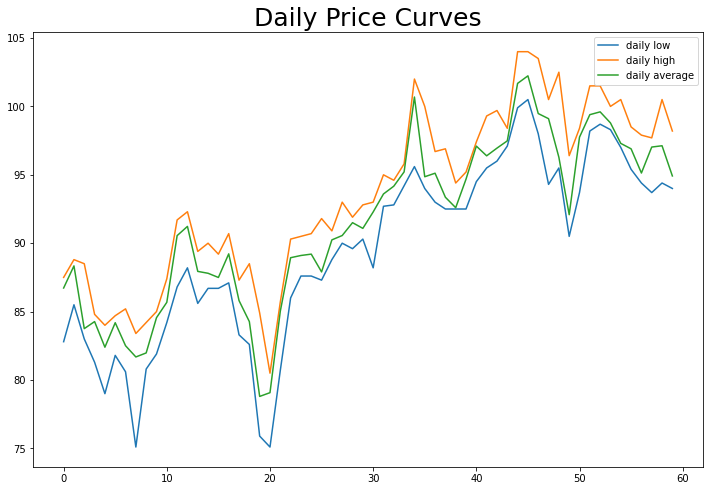

In [510]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(day_low,label='daily low')
ax.plot(day_high,label='daily high')
ax.plot(day_avg,label='daily average')
plt.title('Daily Price Curves',fontsize=25)
plt.legend()
plt.show()

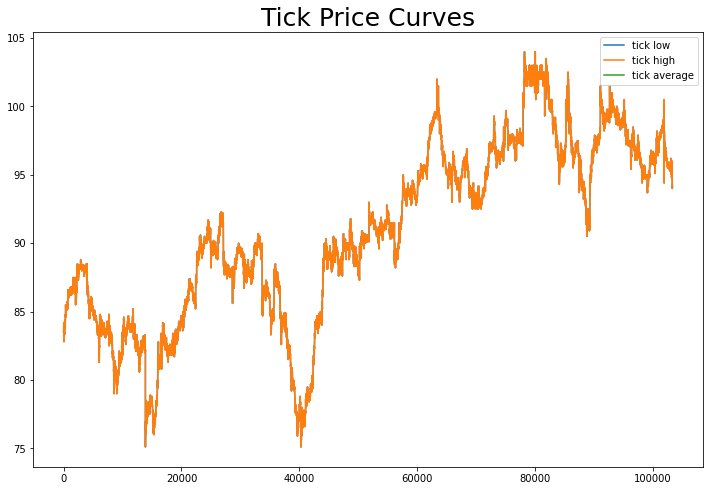

In [516]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(tick_low,label='tick low')
ax.plot(tick_high,label='tick high')
ax.plot(tick_avg,label='tick average')
plt.title('Tick Price Curves',fontsize=25)
plt.legend()
plt.show()

#### Given that all three tick curves are actually very close to each other, we can just use the volume-weighted average for further analysis.

## Distributions

#### Now lets look at the distribution of trade prices

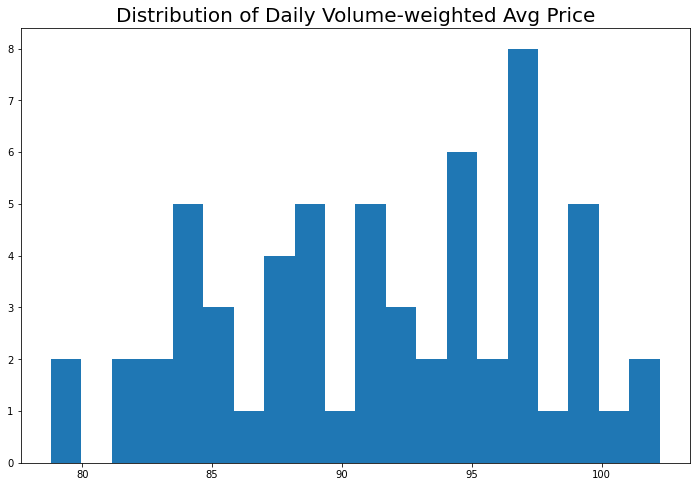

In [299]:
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(day_avg,bins=20)
plt.title('Distribution of Daily Volume-weighted Avg Price',fontsize=20)
plt.show()

In [300]:
tick_bid_ask_spread = [tick_spread[i][0] for i in range(len(tick_spread))]
tick_trade_price = [tick_spread[i][1] for i in range(len(tick_spread))]
tick_trade_volume = [tick_spread[i][2] for i in range(len(tick_spread))]

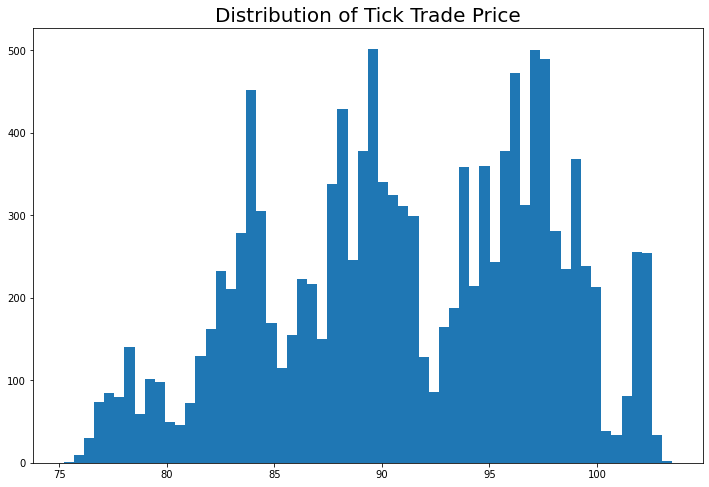

In [305]:
non_zero_tick_trade_price = [price for price in tick_trade_price if price!=0]
fig,ax = plt.subplots(figsize=(12,8))
ax.hist(non_zero_tick_trade_price,bins=60)
plt.title("Distribution of Tick Trade Price",fontsize=20)
plt.show()

## Correlations

### 0. Method

#### To understand the correlations, we avoid both Pearson correlation and Linear Regression. Instead we choose Kendall's correlation. The reasons are as follows
(1) Due to the fact that we are fitting in 2D, the Pearson correlation is just the slope for the standardized variables. But since the trade price is not normally distributed (multiple peaks), the Pearson correlation is a biased estimate of their true correlation. And introducing variance-stabilizing transforms (taking log, or square root) will not fix our problem. So we will not take this route.

(2) Kendall's correlation is less biased in case of noisy data and less sensitive to outliers (since it is based on ranks). We will use this.

### 1. Bid-ask Spread vs Trade Volume on Tick Level

#### We can seem to fit a line with negative slope to it but first of all we need to clean the data up a little bit in the two following way
#### (1) all the points with zero volume but negative bid-ask spread
        It does not make much sense when a bid price is higher than an ask price but the trades are not executed. This could just be due to system errors or simply because the bid and ask are not matched until the next tick (maybe one of the request came in at the end of the prior tick and the system took some extra time to respond). 
#### (2) the top-most point which is very likely to be a outlier, we remove it

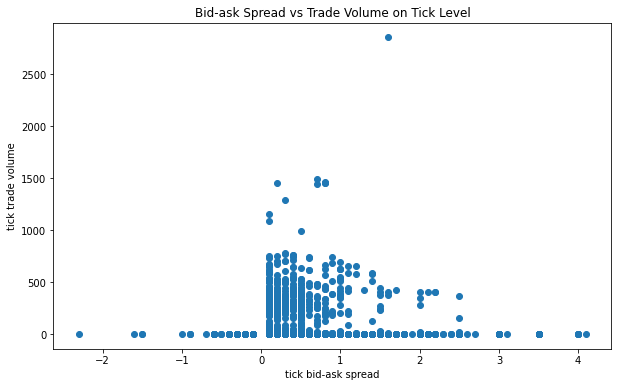

In [350]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(tick_bid_ask_spread,tick_trade_volume)
plt.xlabel('tick bid-ask spread')
plt.ylabel('tick trade volume')
plt.title('Bid-ask Spread vs Trade Volume on Tick Level')
plt.show()

#### We clean up the data and replot

In [357]:
# delete the points with negative bid-ask spread but zero trade volume.
cleaned_tick_bid_ask_spread = [tick_bid_ask_spread[i] for i in range(len(tick_bid_ask_spread)) if (tick_bid_ask_spread[i]>0)]
cleaned_tick_trade_volume = [tick_trade_volume[i] for i in range(len(tick_trade_volume)) if (tick_bid_ask_spread[i]>0)]
cleaned_tick_trade_price = [tick_trade_price[i] for i in range(len(tick_trade_volume)) if (tick_bid_ask_spread[i]>0)]

# delete the top outlier
outlier = cleaned_tick_trade_volume.index(max(cleaned_tick_trade_volume))
cleaned_tick_bid_ask_spread.pop(outlier)
cleaned_tick_trade_volume.pop(outlier)
cleaned_tick_trade_price.pop(outlier)

94.4

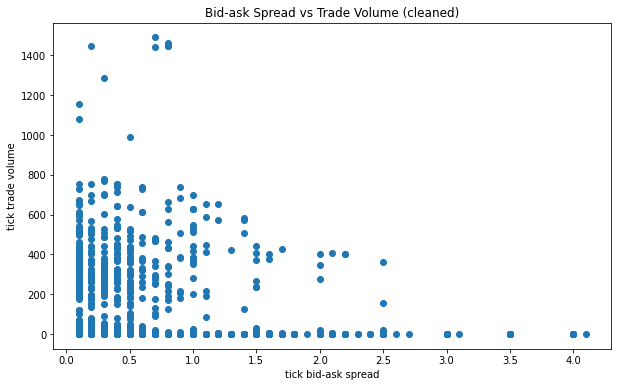

In [358]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(cleaned_tick_bid_ask_spread,cleaned_tick_trade_volume)
plt.xlabel('tick bid-ask spread')
plt.ylabel('tick trade volume')
plt.title('Bid-ask Spread vs Trade Volume (cleaned)')
plt.show()

In [366]:
print("The Kendall's correlation bewteen tick-wise bid-ask spread and trade volume is {}".format(kendalltau(cleaned_tick_bid_ask_spread,cleaned_tick_trade_volume)[0]))

The Kendall's correlation bewteen tick-wise bid-ask spread and trade volume is -0.009914310333545933


#### Conclusion: visually there is a negative correlation but the computed value is not convincing. This is most likely because of the points with zero trading values dragging the correlation down. But it is not obvious to me why those points should be removed (apologies of my lack of financial knowledge).

### 2. Bid-ask Spread on Day Level

#### There should be a line with negative slope being fitted to the data point but similarly there are a few outliers that need to be taken care of

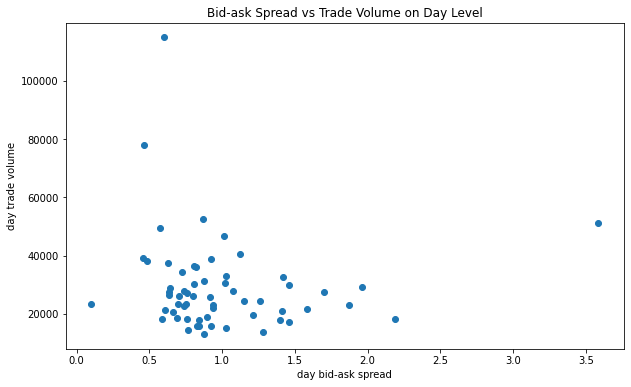

In [353]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(day_spread,day_vol)
plt.xlabel('day bid-ask spread')
plt.ylabel('day trade volume')
plt.title('Bid-ask Spread vs Trade Volume on Day Level')
plt.show()

#### We clean up the data and re-plot

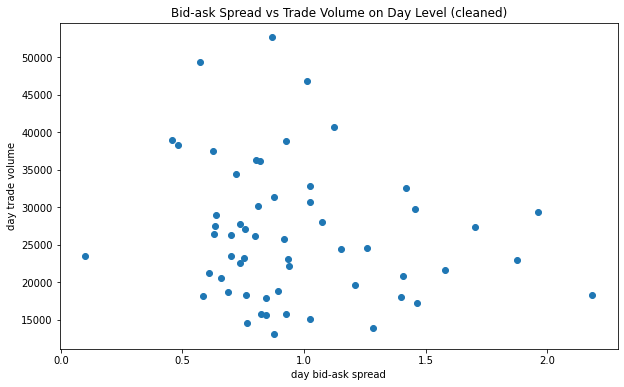

In [390]:
# delete the three outliers
cleaned_day_spread = [day_spread[i] for i in range(len(day_spread)) if (day_vol[i]<65000 and day_spread[i]<3.5)]
cleaned_day_vol = [day_vol[i] for i in range(len(day_spread)) if (day_vol[i]<65000 and day_spread[i]<3.5)]
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(cleaned_day_spread,cleaned_day_vol)
plt.xlabel('day bid-ask spread')
plt.ylabel('day trade volume')
plt.title('Bid-ask Spread vs Trade Volume on Day Level (cleaned)')
plt.show()

In [363]:
print("The Kendall's correlation bewteen daily bid-ask spread and trade volume is {}".format(kendalltau(cleaned_day_spread,cleaned_day_vol)[0]))

The Kendall's correlation bewteen daily bid-ask spread and trade volume is -0.11654135338345867


#### Conclusion: just as intuition suggests, when the bid-ask spread is high (meaning that investors lose more money on making such trade), the trade volume should to down accordingly. And the computed correlation reflects this observation.

### 3. Bid-ask spread vs Trade Price on Tick Level

#### On tick level, the relation is not clear

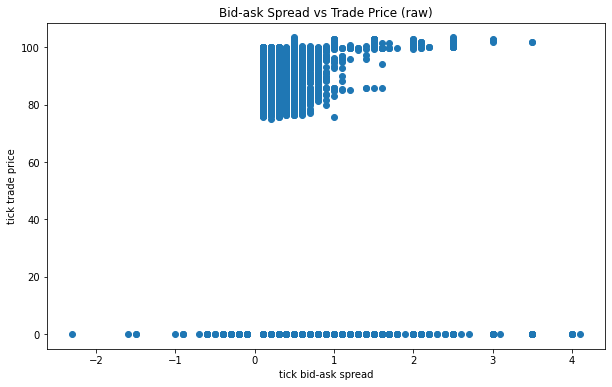

In [347]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(tick_bid_ask_spread,tick_trade_price)
plt.xlabel('tick bid-ask spread')
plt.ylabel('tick trade price')
plt.title('Bid-ask Spread vs Trade Price on Tick Level')
plt.show()

In [365]:
print("The Kendall's correlation bewteen tick-wise bid-ask spread and trade price is {}".format(kendalltau(cleaned_tick_bid_ask_spread,cleaned_tick_trade_price)[0]))

The Kendall's correlation bewteen tick-wise bid-ask spread and trade price is -0.0020488636673406564


#### Again the low correlation could be caused by the points with zero trading volumes.

### 4. Bid-ask spread vs Trade Price on Day Level

#### There is definitely a linear relation between the two. And again there is an outlier with high leverage. 

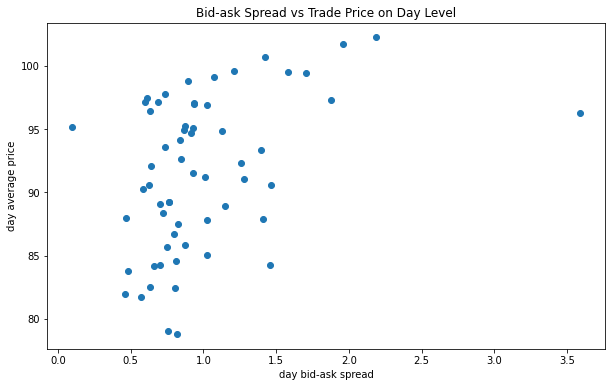

In [354]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(day_spread,day_avg)
plt.xlabel('day bid-ask spread')
plt.ylabel('day average price')
plt.title('Bid-ask Spread vs Trade Price on Day Level')
plt.show()

#### Clean-up and re-plot

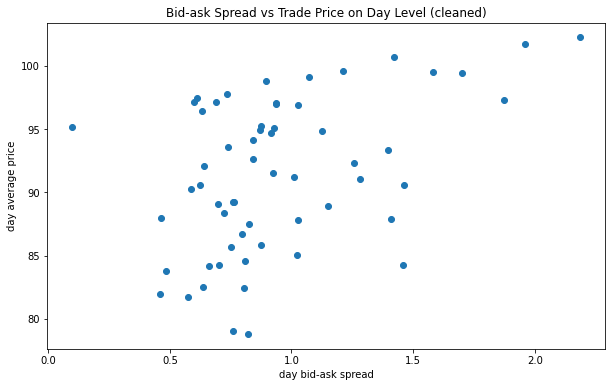

In [391]:
# delete the three outlier
cleaned_day_spread = [day_spread[i] for i in range(len(day_spread)) if (day_spread[i]<3.5)]
cleaned_day_avg = [day_avg[i] for i in range(len(day_avg)) if (day_spread[i]<3.5)]
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(cleaned_day_spread,cleaned_day_avg)
plt.xlabel('day bid-ask spread')
plt.ylabel('day average price')
plt.title('Bid-ask Spread vs Trade Price on Day Level (cleaned)')
plt.show()

In [374]:
print("The Kendall's correlation bewteen daily bid-ask spread and volume-weighted average trade price is {}".format(kendalltau(cleaned_day_spread,cleaned_day_avg)[0]))

The Kendall's correlation bewteen daily bid-ask spread and volume-weighted average trade price is 0.29047340736411453


#### Conclusion: as expected, there is a positive correlation between the two, which is understandable --- intuitively bid-ask spread should be in a small percentage range around the price, so the higher the price, the higher the bid-ask spread. 

### 5. Bid-ask spread vs Price Change on Tick Level

In [381]:
tick_price_change = [tick_trade_price[i]-tick_trade_price[i-1] for i in range(1,len(tick_trade_price))]

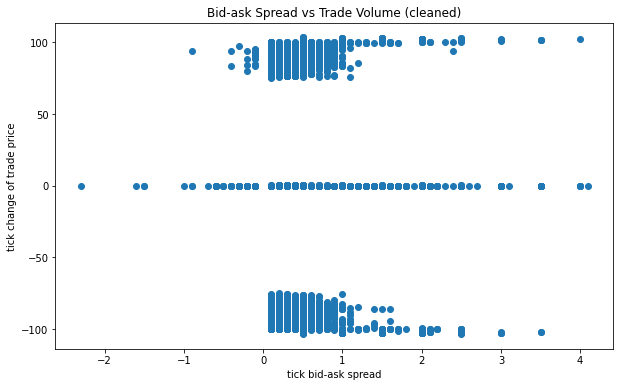

In [384]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(tick_bid_ask_spread[:-1],tick_price_change)
plt.xlabel('tick bid-ask spread')
plt.ylabel('tick change of trade price')
plt.title('Bid-ask Spread vs Trade Volume (cleaned)')
plt.show()

#### Conclusion: the data separates into three parts which is a sign of lack of processing. I don't have enough financial insight to guide further processing of this data.

### 5. Bid-ask spread vs Price Change on Day Level

#### Based on the scatter plot, these two are negatively correlated which mathces our intuition.

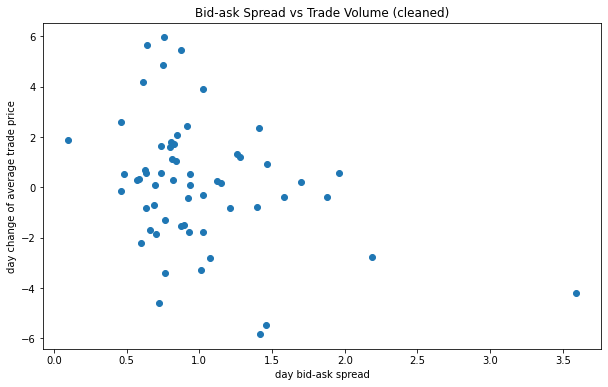

In [386]:
day_price_change = [day_avg[i]-day_avg[i-1] for i in range(1,len(day_avg))]
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(day_spread[:-1],day_price_change)
plt.xlabel('day bid-ask spread')
plt.ylabel('day change of average trade price')
plt.title('Bid-ask Spread vs Trade Volume (cleaned)')
plt.show()

In [387]:
print("The Kendall's correlation bewteen daily bid-ask spread and trade price change is {}".format(kendalltau(day_spread[:-1],day_price_change)[0]))

The Kendall's correlation bewteen daily bid-ask spread and trade price change is -0.16656925774400932


#### Conclusion: intuitively as the bid-ask spread increases, the cost of transaction goes up, followed by a decrease of the demand which will in turn drive the price down. And the computed correlation reflects that.

# Predictive Inferences

### 0. Methods

#### Overall, there is a upward trend for both the daily and tick data. We can use a few different ways for prediction and compare their performaces. Three ways that I can think of at the moment
#### (1) Holt-Winters (double-)Exponential smoothing 
    This probably will do a poor job due to noices and shocks if we want to use it to predict the price. But as the name suggests, we can definitely use Holt-Winters algorithm to smooth out the jumps to capture some of the trend
#### (2) Models in the ARMA family
    These models will give very good fitting as well as strong predictability but we do need to worry about (weak-sense) stationarity as the mean is definitely changing. There are three way to fix this is: 
    (a) to estimate the trend using Holt-Winters then remove the trend before fitting ARMA-like models
    (b) we can use diffencing. However, differencing will cause certain features of the signal to be lost and can easily lead to over-differencing thus need to be used with great caution.
    (c) Simply do a ensemble ARIMA model based on AIC and BIC and the bad fit will automatically have small weights in the final ensembled prediction,
#### (3) LSTM
    This requires the least statistical insight and will definitely provide very good result, however, the downside is that it takes long to train and lack intepretability.
    
    
#### Here we will focus on (2)(c) Ensemble ARIMA and (3) LSTM and we will use the day average price for ensemble ARIMA and use the tick trade price for LSTM.

### 1. Ensemble ARIMA

#### First check stationarity and most likely we will not have this luxury. We run two tests with different flavors
(1) (augmented) Dickey-Fuller Test: this is a unit root test, powerful but has a strong assumption and have low testing power for short-memory time-series

(2) KPSS Test: this is a non-parametric test for (trend)-stationarity, has weak testing power but also requires weaker assumption

Note that the null hypothesis of these two tests are opposite to each other. For stationarity we want to reject null of Dickey-Fuller test and accept the null of KPSS test.

In [413]:
ADF_test = adfuller(day_avg)
if ADF_test[4]['1%'] > ADF_test[0]: 
    print('Based on Dickey-Fuller Test, the underlying stochastic process of the price is stationary.')
else:
    print('Based on Dickey-Fuller Test, the underlying stochastic process of the price is non-stationary.')

KPSS_test = kpss(day_avg)
if KPSS_test[3]['10%'] > KPSS_test[0]:
    print('Based on Dickey-Fuller Test, the underlying stochastic process of the price is stationary.')
else:
    print('Based on Dickey-Fuller Test, the underlying stochastic process of the price is non-stationary.')

Based on Dickey-Fuller Test, the underlying stochastic process of the price is non-stationary.
Based on Dickey-Fuller Test, the underlying stochastic process of the price is non-stationary.


#### As expected, we might need to take differencing. To determine the maximum order or integration (differencing), we look at the partial auto-correlation plot

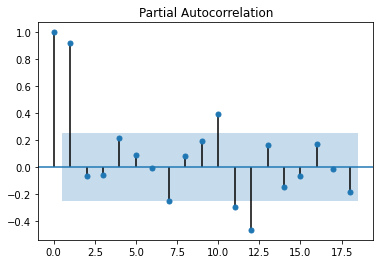

In [418]:
df = pd.DataFrame(day_avg)
plot_pacf(df)
plt.show()

#### As expected, the partial auto correlation quickly drops off after 1 lag. We will only take a maximum of 1 differencing in training our ARIMA models.

#### Next we need to determine the maximum number of lags to include in the ARMA model. To do this, we compute the Hurst exponent, which is reflects the degree of long-term dependence. 

In [444]:
# implementation of calculation of Hurst Exponent 
def CalcHurstExp(ts):  
    lags = range(2, 30)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]  
    poly = np.polyfit(np.log(lags), np.log(tau), 1)  
    hurst = poly[0]*2.0  
    return max(hurst,0)

In [445]:
print("The Hurst exponent of the price time-series is estimated to be {}.".format(CalcHurstExp(day_avg)))

The Hurst exponent of the price time-series is estimated to be 0.0733736899515367.


#### We will only include upto degree 3 terms based on this. We will take the price of the first 56 days out for training and leave the last 4 days for testing. Since we are most interested in prediction of a short term, we do not extend the testing data for more than 10% of total length of the time-series. Plus, these models themselves are only good for predictions within a short time window due to the fast-changing nature of the market. 

In [480]:
# compute the corresponding model weights according to their AIC scores
def computeWeights(AIC):
    min_AIC = min(AIC)
    AIC = np.array(AIC)
    prob = []
    for i in range(len(AIC)):
        prob.append(math.exp((min_AIC-AIC[i])/2))
    prob = np.array(prob)
    return prob/sum(prob)
# compute the ensemble fitted model based on the model weights computed
def computeEnsemble(models,weights):
    ensemble=np.array([0 for _ in range(len(models[0]))])
    for i in range(len(models)):
        ensemble = ensemble + np.array(models[i])*weights[i]
    return list(ensemble)


In [596]:
# set the degrees
d_max = 1
p_max = 3
q_max = 3

original_ts = day_avg
training_length = math.ceil(len(original_ts)*0.95)
training_ts = original_ts[:training_length]


predictions = [] # a 2D array that stores the predicted values of all fitted models
AIC = [] # an 1D array that stores AIC scores
orders = []
for d in range(d_max+1):
    for p in range(1,p_max+1):
        for q in range(0,q_max+1):
            try:
                fitted_model = SARIMAX(training_ts,order=(p,d,q),enforce_stationarity=False,enforce_invertibility=False).fit(disp=-1)
                predictions.append(fitted_model.predict(start=1, end=len(original_ts)))
                orders.append((p,d,q))
                AIC.append(fitted_model.aic)
                weights = computeWeights(AIC)
                orders_and_weights = (orders, weights)    
            except:
                continue
        
ensemble = computeEnsemble(predictions,weights)

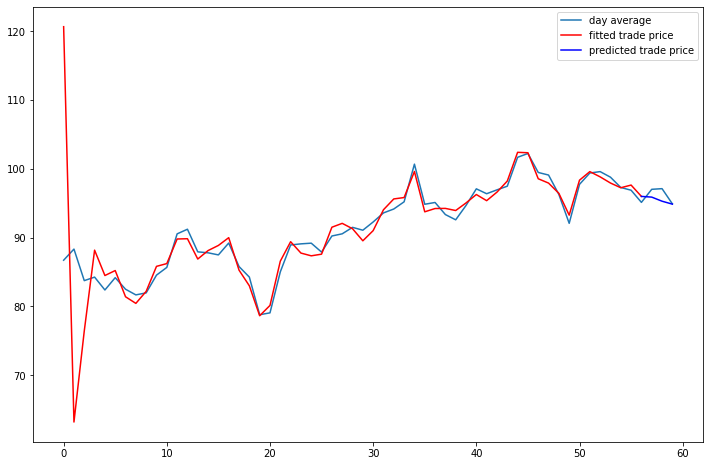

In [720]:
x = range(len(original_ts))
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(day_avg,label='day average')
ax.plot(ensemble[:training_length], color='r', label='fitted trade price' )
ax.plot(x[training_length-1:],ensemble[training_length-1:],color='b',label='predicted trade price')
plt.legend()
plt.show()

### 2. LSTM 

In [571]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

#### We will use the tick data instead of the day data since we will definitely need a lot more training data.

In [543]:
tick_avg = [tick_spread[i][1] for i in range(len(tick_spread)) if tick_spread[i][1]!=0]

In [722]:
training_length = math.ceil(len(tick_avg)*0.9)
data = [[x] for x in tick_avg]
traning_data = [data[i] for i in range(training_length)]
testing_data = [data[i] for i in range(training_length-window_size,len(data))]

In [702]:
scaler = MinMaxScaler(feature_range=(0,1))

In [703]:
scaled_training_data = scaler.fit_transform(training_data)
scaled_testing_data = scaler.fit_transform(testing_data)

In [704]:
# Set the window size to 200
window_size = 200
x_training = []
y_training = []
for i in range(window_size,len(scaled_training_data)):
    x_training.append(scaled_training_data[i-window_size:i,0])
    y_training.append(scaled_training_data[i,0])

x_testing = []
y_testing = []
for i in range(window_size,len(scaled_testing_data)):
    x_testing.append(scaled_testing_data[i-window_size:i]) 

In [705]:
# reshaping both training and testing data
x_training = np.array(x_training)
y_training = np.array(y_training)
x_training = np.reshape(x_training,(x_training.shape[0],x_training.shape[1],1))
y_training = np.reshape(y_training,(y_training.shape[0],1))

x_testing = np.array(x_testing)
x_testing = np.reshape(x_testing,(x_testing.shape[0],x_testing.shape[1],1))

In [630]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(100,return_sequences=True,input_shape=(x_training.shape[1],1)))
LSTM_model.add(LSTM(100,return_sequences=False))
LSTM_model.add(Dense(100))
LSTM_model.add(Dense(25))
LSTM_model.add(Dense(1))

In [631]:
LSTM_model.compile(optimizer='adam',loss='mean_squared_error')

In [632]:
LSTM_model.fit(x_training,y_training,batch_size=1,epochs=1)

Epoch 1/1
11267/11267 [==============================] - 934s 83ms/step - loss: 5.3619e-04A: 0s - loss: 5.35


In [706]:
prediction = scaler.inverse_transform(LSTM_model.predict(x_testing))

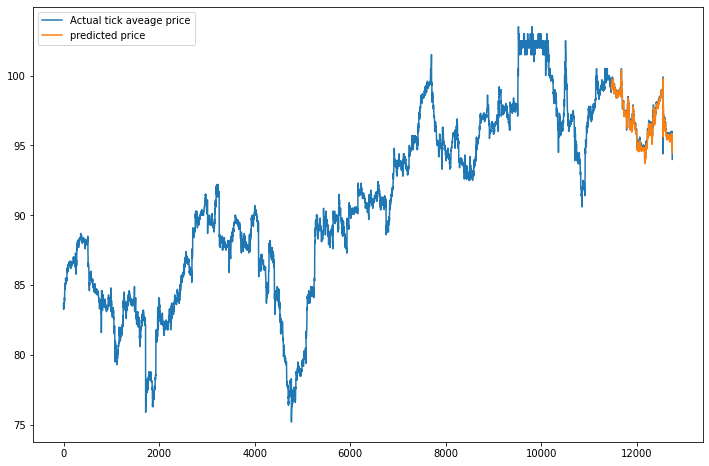

In [724]:
fig, ax = plt.subplots(figsize=(12,8))
x = range(len(data))
ax.plot(data,label='Actual tick aveage price')
ax.plot(x[training_length:],prediction,label='predicted price')
plt.legend()
plt.show()

#### The overall prediction is much more accureate than the ensemble ARIMA model. However, it took longer for adjusting the RNN's structure and also longer time to train. The most important shortcomming being the lack of interpretability.